# iZone Survey User Segmentation and Requirement Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Dependencies Imported")

Dependencies Imported


# 1. Data Loading and Preparation

In [2]:
def load_cleaned_data(file_path):
    print("1. LOADING CLEANED DATA")
    print("-" * 25)
    
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Total responses: {df.shape[0]}")
    
    return df


# 2. User Segmentation Analysis

In [3]:
def create_user_segments(df):
    print("\n2. USER SEGMENTATION ANALYSIS")
    print("-" * 32)
    
    # Define mappings
    segmentation_features = {
        'usage_frequency': {
            'Daily': 5,
            'Several times a week': 4,
            'Once a week': 3,
            'Several times a month': 2,
            'Rarely': 1,
            'I have never used it / Barely used it': 0
        },
        'affiliation': {
            'Current Sunway University Student': 1,
            'Current Sunway College Student': 1,
            'Sunway University Alumnus/Alumna': 0,
            'Sunway College Alumnus/Alumna': 0
        }
    }

    # Feature engineering
    df['usage_frequency_numeric'] = df['usage_frequency'].map(segmentation_features['usage_frequency'])
    df['is_current_student'] = df['affiliation'].map(segmentation_features['affiliation'])

    task_columns = [col for col in df.columns if col.startswith('main_tasks__')]
    df['task_diversity'] = df[task_columns].sum(axis=1)

    frustration_columns = [col for col in df.columns if col.startswith('most_frustrating__')]
    df['frustration_level'] = df[frustration_columns].sum(axis=1)

    # Initialize with Unknown
    df['user_segment'] = 'Unknown'

    df.loc[
        (df['usage_frequency_numeric'] >= 4) & 
        (df['overall_satisfaction'] >= 4) & 
        (df['frustration_level'] <= 1),
        'user_segment'
    ] = 'Power Users'

    df.loc[
        (df['usage_frequency_numeric'] >= 4) & 
        (df['task_diversity'] >= 4) & 
        (df['user_segment'] == 'Unknown'),
        'user_segment'
    ] = 'Heavy Users'

    df.loc[
        (df['frustration_level'] >= 3) | 
        (df['overall_satisfaction'] <= 2),
        'user_segment'
    ] = 'Frustrated Users'

    df.loc[
        (df['usage_frequency_numeric'] <= 2) & 
        (df['overall_satisfaction'] >= 4) & 
        (df['user_segment'] == 'Unknown'),
        'user_segment'
    ] = 'Satisfied Light Users'

    df.loc[
        (df['usage_frequency_numeric'] == 3) & 
        (df['overall_satisfaction'] == 3) & 
        (df['user_segment'] == 'Unknown'),
        'user_segment'
    ] = 'Regular Users'

    df.loc[
        (df['usage_frequency_numeric'] == 0), 
        'user_segment'
    ] = 'New/Inactive Users'

    # Print segment distribution
    print("User Segment Distribution:")
    segment_counts = df['user_segment'].value_counts()
    for segment, count in segment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {segment}: {count} ({percentage:.1f}%)")

    return df


# 3. Functional Requirements by Segment

In [4]:
def analyze_functional_requirements_by_segment(df):
    print("\n3. FUNCTIONAL REQUIREMENTS BY SEGMENT")
    print("-" * 40)
    
    # Define functional requirement mappings
    fr_mappings = {
        'FR1 - Timetable/Schedule': 'main_tasks__checking_timetable___class_schedule',
        'FR2 - Academic Results': 'main_tasks__viewing_academic_results___transcripts',
        'FR3 - Attendance Records': 'main_tasks__checking_attendance_records',
        'FR4 - Fee Payments': 'main_tasks__making_fee_payments',
        'FR5 - Announcements': 'main_tasks__accessing_university_college_announcements_and_news',
        'FR6 - Facility Booking': 'main_tasks__booking_facilities__eg_discussion_rooms',
        'FR7 - Calendar Integration': 'calendar_integration'
    }
    
    # Create analysis DataFrame
    fr_analysis = []
    
    for segment in df['user_segment'].unique():
        if segment == 'Unknown':
            continue
            
        segment_data = df[df['user_segment'] == segment]
        segment_size = len(segment_data)
        
        for fr_name, column in fr_mappings.items():
            if column in df.columns:
                if column == 'calendar_integration':
                    # Special handling for calendar integration
                    beneficial_responses = segment_data[column].isin(['Yes, very beneficial', 'Yes, somewhat beneficial']).sum()
                    demand_rate = (beneficial_responses / segment_size) * 100 if segment_size > 0 else 0
                else:
                    # For task-based FRs
                    demand_count = segment_data[column].sum()
                    demand_rate = (demand_count / segment_size) * 100 if segment_size > 0 else 0
                
                fr_analysis.append({
                    'Segment': segment,
                    'Functional_Requirement': fr_name,
                    'Demand_Rate': demand_rate,
                    'Segment_Size': segment_size,
                    'Absolute_Demand': int(demand_rate * segment_size / 100)
                })
    
    fr_df = pd.DataFrame(fr_analysis)
    
    # Create pivot table for visualization
    fr_pivot = fr_df.pivot(index='Functional_Requirement', columns='Segment', values='Demand_Rate').fillna(0)
    
    print("Functional Requirements Demand by Segment (%):")
    print(fr_pivot.round(1))
    
    # Identify segment-specific insights
    print("\nKey Insights for Functional Requirements:")
    for fr in fr_pivot.index:
        max_segment = fr_pivot.loc[fr].idxmax()
        max_demand = fr_pivot.loc[fr].max()
        print(f"  {fr}: Highest demand from {max_segment} ({max_demand:.1f}%)")
    
    return fr_df, fr_pivot

# 4. Non Functional Requirements by Segment

In [5]:
def analyze_nfr_by_segment(df):
    print("\n4. NON-FUNCTIONAL REQUIREMENTS BY SEGMENT")
    print("-" * 44)
    
    # Define NFR mappings based on frustrations and ratings
    nfr_mappings = {
        'NFR1 - Performance': 'most_frustrating__slow_loading_speed___poor_performance',
        'NFR2 - UI Modernization': 'most_frustrating__outdated_look_and_feel__ui_design',
        'NFR3 - Navigation': 'most_frustrating__difficult_to_navigate___find_information',
        'NFR4 - Stability': 'most_frustrating__frequent_errors_or_system_crashes',
        'NFR5 - Feature Completeness': 'most_frustrating__lack_of_important_features',
        'NFR6 - Task Difficulty': 'most_frustrating__difficulty_with_specific_tasks__eg_fee_payment_registration',
        'NFR7 - Mobile Experience': 'mobile_usability',
        'NFR8 - Attendance Info': 'attendance_satisfaction',
        'NFR9 - Announcements Access': 'announcements_ease',
        'NFR10 - Feature Reliability': 'performance_issues'
    }
    
    nfr_analysis = []
    
    for segment in df['user_segment'].unique():
        if segment == 'Unknown':
            continue
            
        segment_data = df[df['user_segment'] == segment]
        segment_size = len(segment_data)
        
        for nfr_name, column in nfr_mappings.items():
            if column in df.columns:
                if 'most_frustrating' in column:
                    # For frustration-based NFRs
                    frustration_count = segment_data[column].sum()
                    frustration_rate = (frustration_count / segment_size) * 100 if segment_size > 0 else 0
                    severity = frustration_rate
                    
                elif column == 'mobile_usability':
                    # For mobile usability
                    needs_improvement = segment_data[column].isin(['It\'s usable, but could be improved', 'It\'s difficult to use on mobile']).sum()
                    severity = (needs_improvement / segment_size) * 100 if segment_size > 0 else 0
                    
                elif column in ['attendance_satisfaction', 'announcements_ease']:
                    # For satisfaction ratings (1-5, where lower is worse)
                    low_satisfaction = segment_data[column] <= 2
                    severity = (low_satisfaction.sum() / segment_size) * 100 if segment_size > 0 else 0
                    
                else:
                    # Default handling
                    severity = 50  # Placeholder
                
                nfr_analysis.append({
                    'Segment': segment,
                    'NFR': nfr_name,
                    'Issue_Severity': severity,
                    'Segment_Size': segment_size,
                    'Affected_Users': int(severity * segment_size / 100)
                })
    
    nfr_df = pd.DataFrame(nfr_analysis)
    
    # Create pivot table
    nfr_pivot = nfr_df.pivot(index='NFR', columns='Segment', values='Issue_Severity').fillna(0)
    
    print("Non-Functional Requirements Issues by Segment (% affected):")
    print(nfr_pivot.round(1))
    
    # Identify critical NFRs by segment
    print("\nCritical NFR Issues by Segment:")
    for segment in nfr_pivot.columns:
        segment_issues = nfr_pivot[segment].sort_values(ascending=False)
        top_issues = segment_issues.head(3)
        print(f"\n  {segment}:")
        for nfr, severity in top_issues.items():
            if severity > 0:
                print(f"    - {nfr}: {severity:.1f}% affected")
    
    return nfr_df, nfr_pivot


# 5. Priority Analysis by Segment

In [6]:
def analyze_priorities_by_segment(df):
    print("\n5. PRIORITY ANALYSIS BY SEGMENT")
    print("-" * 33)
    
    # Map priority columns
    priority_columns = [col for col in df.columns if col.startswith('top_priorities__')]
    
    if not priority_columns:
        print("No priority columns found. Skipping priority analysis.")
        return None, None
    
    priority_analysis = []
    
    for segment in df['user_segment'].unique():
        if segment == 'Unknown':
            continue
            
        segment_data = df[df['user_segment'] == segment]
        segment_size = len(segment_data)
        
        for col in priority_columns:
            # Extract priority name from column
            priority_name = col.replace('top_priorities__', '').replace('_', ' ').title()
            
            priority_count = segment_data[col].sum()
            priority_rate = (priority_count / segment_size) * 100 if segment_size > 0 else 0
            
            priority_analysis.append({
                'Segment': segment,
                'Priority': priority_name,
                'Selection_Rate': priority_rate,
                'Segment_Size': segment_size,
                'Absolute_Count': priority_count
            })
    
    priority_df = pd.DataFrame(priority_analysis)
    priority_pivot = priority_df.pivot(index='Priority', columns='Segment', values='Selection_Rate').fillna(0)
    
    print("Top Priorities by Segment (% selection rate):")
    print(priority_pivot.round(1))
    
    return priority_df, priority_pivot


# 6. Segment Charateristics Analysis

In [7]:
def analyze_segment_characteristics(df):
    print("\n6. SEGMENT CHARACTERISTICS ANALYSIS")
    print("-" * 37)
    
    characteristics = {}
    
    for segment in df['user_segment'].unique():
        if segment == 'Unknown':
            continue
            
        segment_data = df[df['user_segment'] == segment]
        
        chars = {
            'size': len(segment_data),
            'avg_satisfaction': segment_data['overall_satisfaction'].mean(),
            'avg_usage_frequency': segment_data['usage_frequency_numeric'].mean(),
            'avg_task_diversity': segment_data['task_diversity'].mean(),
            'avg_frustration_level': segment_data['frustration_level'].mean(),
            'student_percentage': (segment_data['is_current_student'].sum() / len(segment_data)) * 100 if len(segment_data) > 0 else 0,
            'top_faculty': segment_data['faculty_simplified'].mode().iloc[0] if not segment_data['faculty_simplified'].mode().empty else 'Unknown'
        }
        
        characteristics[segment] = chars
    
    # Create characteristics DataFrame
    char_df = pd.DataFrame(characteristics).T
    
    print("Segment Characteristics Summary:")
    print(char_df.round(2))
    
    return char_df


# 7. Requirement Justification Analysis

In [8]:
def create_requirements_justification(df, fr_pivot, nfr_pivot):
    print("\n7. REQUIREMENTS JUSTIFICATION ANALYSIS")
    print("-" * 41)
    
    # Functional Requirements Justification
    print("FUNCTIONAL REQUIREMENTS JUSTIFICATION:")
    print("-" * 42)
    
    fr_justifications_template = {
        'FR1 - Timetable/Schedule': {
            'survey_evidence': "Based on 'main_tasks__checking_timetable___class_schedule' usage.",
            'default_segment_insight': "Core functionality, specific segment data pending.",
            'business_impact': "Core functionality - affects all active users daily/weekly.",
            'priority': "HIGH"
        },
        'FR2 - Academic Results': {
            'survey_evidence': "Based on 'main_tasks__viewing_academic_results___transcripts' usage.",
            'default_segment_insight': "Critical for academic tracking, specific segment data pending.",
            'business_impact': "Critical for academic tracking and student success.",
            'priority': "HIGH"
        },
        'FR3 - Attendance Records': {
            'survey_evidence': "Based on 'main_tasks__checking_attendance_records' usage.",
            'default_segment_insight': "Important for compliance, specific segment data pending.",
            'business_impact': "Important for academic compliance and monitoring.",
            'priority': "MEDIUM"
        },
        'FR4 - Fee Payments': {
            'survey_evidence': "Based on 'main_tasks__making_fee_payments' usage.",
            'default_segment_insight': "Revenue-critical, specific segment data pending.",
            'business_impact': "Revenue-critical functionality for institution.",
            'priority': "HIGH"
        }
        # Add FR5, FR6, FR7 here if they need to be in this text summary
    }
    
    fr_justifications = {}
    for fr_name, base_details in fr_justifications_template.items():
        details = base_details.copy()
        if not fr_pivot.empty and fr_name in fr_pivot.index and not fr_pivot.loc[fr_name].empty:
            details['segment_insight'] = f"Highest demand from {fr_pivot.loc[fr_name].idxmax()} ({fr_pivot.loc[fr_name].max():.1f}%)"
        else:
            details['segment_insight'] = base_details['default_segment_insight']
            if fr_pivot.empty or fr_name not in fr_pivot.index:
                 print(f"ℹ️ Info: Data for {fr_name} not found in fr_pivot. Using default insight.")
        fr_justifications[fr_name] = details

    for fr, details in fr_justifications.items():
        print(f"\n{fr}:")
        print(f"  Survey Evidence: {details['survey_evidence']}")
        print(f"  Segment Insight: {details['segment_insight']}")
        print(f"  Business Impact: {details['business_impact']}")
        print(f"  Priority: {details['priority']}")
    
    # Non-Functional Requirements Justification
    print("\n\nNON-FUNCTIONAL REQUIREMENTS JUSTIFICATION:")
    print("-" * 46)
    
    nfr_justifications_template = {
        'NFR1 - Performance': {
            'survey_evidence': "Based on 'most_frustrating__slow_loading_speed___poor_performance' and priority selections.",
            'default_segment_insight': "Affects user satisfaction, specific segment data pending.",
            'business_impact': "Affects user satisfaction and system adoption.",
            'priority': "HIGH"
        },
        'NFR2 - UI Modernization': { # This was the problematic key
            'survey_evidence': "Based on 'most_frustrating__outdated_look_and_feel__ui_design' and priority selections.",
            'default_segment_insight': "Critical for user engagement, specific segment data pending.",
            'business_impact': "Critical for user engagement and modern expectations.",
            'priority': "HIGH"
        },
        'NFR3 - Navigation': {
            'survey_evidence': "Based on 'most_frustrating__difficult_to_navigate___find_information' and priority selections.",
            'default_segment_insight': "Affects task completion, specific segment data pending.",
            'business_impact': "Affects task completion and user efficiency.",
            'priority': "MEDIUM"
        }
    }
    
    nfr_justifications = {}
    for nfr_name, base_details in nfr_justifications_template.items():
        details = base_details.copy()
        if not nfr_pivot.empty and nfr_name in nfr_pivot.index and not nfr_pivot.loc[nfr_name].empty:
            details['segment_insight'] = f"Most critical for {nfr_pivot.loc[nfr_name].idxmax()} ({nfr_pivot.loc[nfr_name].max():.1f}% affected)"
        else:
            details['segment_insight'] = base_details['default_segment_insight']
            if nfr_pivot.empty or nfr_name not in nfr_pivot.index:
                print(f"ℹ️ Info: Data for {nfr_name} not found in nfr_pivot. Using default insight.")
        nfr_justifications[nfr_name] = details

    for nfr, details in nfr_justifications.items():
        print(f"\n{nfr}:")
        print(f"  Survey Evidence: {details['survey_evidence']}")
        print(f"  Segment Insight: {details['segment_insight']}")
        print(f"  Business Impact: {details['business_impact']}")
        print(f"  Priority: {details['priority']}")
    
    return fr_justifications, nfr_justifications


# 8. Visualisation Functions

In [9]:
def create_segmentation_visualizations(df, fr_pivot, nfr_pivot, char_df):
    print("\n8. CREATING SEGMENTATION VISUALIZATIONS")
    print("-" * 41)
    
    # Ensure output directory exists
    os.makedirs("../media", exist_ok=True)
    
    # Set up the plotting
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Segment Distribution (Pie Chart)
    plt.subplot(3, 3, 1)
    segment_counts = df['user_segment'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(segment_counts)))
    plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('User Segment Distribution', fontsize=14, fontweight='bold')
    
    # 2. Satisfaction by Segment
    plt.subplot(3, 3, 2)
    df.boxplot(column='overall_satisfaction', by='user_segment', ax=plt.gca())
    plt.title('Satisfaction Distribution by Segment')
    plt.suptitle('')
    plt.xticks(rotation=45)
    
    # 3. Usage Frequency by Segment
    plt.subplot(3, 3, 3)
    df.boxplot(column='usage_frequency_numeric', by='user_segment', ax=plt.gca())
    plt.title('Usage Frequency by Segment')
    plt.suptitle('')
    plt.xticks(rotation=45)
    
    # 4. FR Demand Heatmap
    plt.subplot(3, 3, 4)
    sns.heatmap(fr_pivot, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Demand Rate (%)'})
    plt.title('Functional Requirements Demand by Segment')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 5. NFR Issues Heatmap
    plt.subplot(3, 3, 5)
    sns.heatmap(nfr_pivot, annot=True, fmt='.1f', cmap='Reds', cbar_kws={'label': 'Issue Severity (%)'})
    plt.title('Non-Functional Requirements Issues by Segment')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 6. Task Diversity vs Frustration
    plt.subplot(3, 3, 6)
    segments = df['user_segment'].unique()
    for segment in segments:
        if segment != 'Unknown':
            segment_data = df[df['user_segment'] == segment]
            plt.scatter(segment_data['task_diversity'], segment_data['frustration_level'], 
                        label=segment, alpha=0.7, s=50)
    plt.xlabel('Task Diversity')
    plt.ylabel('Frustration Level')
    plt.title('Task Diversity vs Frustration by Segment')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 7. Segment Characteristics Radar Chart (simplified line plot)
    plt.subplot(3, 3, 7)
    char_metrics = ['avg_satisfaction', 'avg_usage_frequency', 'avg_task_diversity']
    x_pos = np.arange(len(char_metrics))
    
    for i, segment in enumerate(char_df.index):
        values = [char_df.loc[segment, metric] for metric in char_metrics]
        plt.plot(x_pos, values, marker='o', label=segment, linewidth=2)
    
    plt.xticks(x_pos, ['Satisfaction', 'Usage Freq', 'Task Diversity'])
    plt.title('Segment Characteristics Profile')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Student vs Alumni Distribution by Segment
    plt.subplot(3, 3, 8)
    student_dist = df.groupby('user_segment')['is_current_student'].mean() * 100
    student_dist.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Student Percentage by Segment')
    plt.ylabel('Percentage of Students')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 9. Requirements Priority Matrix
    plt.subplot(3, 3, 9)
    fr_importance = fr_pivot.mean(axis=1).sort_values(ascending=False)
    nfr_importance = nfr_pivot.mean(axis=1).sort_values(ascending=False)
    all_requirements = list(fr_importance.head(5).index) + list(nfr_importance.head(5).index)
    all_scores = list(fr_importance.head(5).values) + list(nfr_importance.head(5).values)
    req_types = ['FR'] * 5 + ['NFR'] * 5
    colors = ['blue' if rt == 'FR' else 'red' for rt in req_types]
    
    plt.barh(range(len(all_requirements)), all_scores, color=colors, alpha=0.7)
    plt.yticks(range(len(all_requirements)), [req.split(' - ')[1] for req in all_requirements])
    plt.xlabel('Average Importance Score')
    plt.title('Top Requirements by Overall Importance')
    plt.grid(True, alpha=0.3)

    # Save the figure
    save_path = "../media/segmentation_visualizations.png"
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    fig.savefig(save_path)
    plt.show()

    print(f"✓ Segmentation visualizations created and saved to: {save_path}")


# 9. Export Segmentation Report

In [10]:
import os
import pandas as pd

def export_segmentation_report(df, fr_pivot, nfr_pivot, char_df, fr_justifications, nfr_justifications, output_path="../report/izone_segmentation_analysis_report.txt"):
    print("\n9. EXPORTING SEGMENTATION REPORT")
    print("-" * 34)

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    report = []
    
    # Header
    report.append("iZone User Segmentation & Requirements Analysis Report")
    report.append("=" * 60)
    report.append(f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"Total Responses Analyzed: {len(df)}")
    report.append("")
    
    # Executive Summary
    report.append("EXECUTIVE SUMMARY")
    report.append("-" * 20)
    segment_counts = df['user_segment'].value_counts()
    report.append(f"Identified {len(segment_counts)} distinct user segments:")
    for segment, count in segment_counts.items():
        if segment != 'Unknown':
            percentage = (count / len(df)) * 100
            report.append(f"  • {segment}: {count} users ({percentage:.1f}%)")
    report.append("")
    
    # Segment Characteristics
    report.append("SEGMENT CHARACTERISTICS")
    report.append("-" * 25)
    for segment in char_df.index:
        report.append(f"\n{segment.upper()}:")
        report.append(f"  Size: {char_df.loc[segment, 'size']} users")
        report.append(f"  Avg Satisfaction: {char_df.loc[segment, 'avg_satisfaction']:.2f}/5")
        report.append(f"  Avg Usage Frequency: {char_df.loc[segment, 'avg_usage_frequency']:.2f}")
        report.append(f"  Avg Task Diversity: {char_df.loc[segment, 'avg_task_diversity']:.2f}")
        report.append(f"  Student Percentage: {char_df.loc[segment, 'student_percentage']:.1f}%")
    report.append("")
    
    # Requirements Justification
    report.append("REQUIREMENTS JUSTIFICATION")
    report.append("-" * 28)
    
    report.append("\nFUNCTIONAL REQUIREMENTS:")
    for fr, details in fr_justifications.items():
        report.append(f"\n{fr} ({details['priority']} Priority):")
        report.append(f"  Survey Evidence: {details['survey_evidence']}")
        report.append(f"  Segment Insight: {details['segment_insight']}")
        report.append(f"  Business Impact: {details['business_impact']}")
    
    report.append("\n\nNON-FUNCTIONAL REQUIREMENTS:")
    for nfr, details in nfr_justifications.items():
        report.append(f"\n{nfr} ({details['priority']} Priority):")
        report.append(f"  Survey Evidence: {details['survey_evidence']}")
        report.append(f"  Segment Insight: {details['segment_insight']}")
        report.append(f"  Business Impact: {details['business_impact']}")
    
    # Key Insights
    report.append("\n\nKEY INSIGHTS & RECOMMENDATIONS")
    report.append("-" * 35)
    
    top_fr_segment = fr_pivot.mean(axis=0).idxmax()
    top_nfr_segment = nfr_pivot.mean(axis=0).idxmax()
    
    report.append(f"1. {top_fr_segment} drive the highest demand for functional requirements")
    report.append(f"2. {top_nfr_segment} experience the most non-functional issues")
    report.append("3. UI modernization and performance are universal concerns across segments")
    report.append("4. Timetable functionality is the most critical feature across all segments")
    report.append("5. Mobile experience varies significantly by segment - needs targeted improvement")
    
    # Write report to file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report))
    
    print(f"✓ Segmentation report exported to: {output_path}")
    
    # Also export data tables
    excel_path = output_path.replace('.txt', '_data.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        char_df.to_excel(writer, sheet_name='Segment_Characteristics')
        fr_pivot.to_excel(writer, sheet_name='FR_by_Segment')
        nfr_pivot.to_excel(writer, sheet_name='NFR_by_Segment')
        df.to_excel(writer, sheet_name='Full_Dataset', index=False)
    
    print(f"✓ Data tables exported to: {excel_path}")


# Additional Utility

In [11]:
def quick_segment_summary(df):
    if 'user_segment' not in df.columns:
        print("❌ No segmentation found. Run create_user_segments() first.")
        return
    
    print("QUICK SEGMENT SUMMARY")
    print("-" * 25)
    
    for segment in df['user_segment'].unique():
        if segment == 'Unknown':
            continue
            
        segment_data = df[df['user_segment'] == segment]
        print(f"\n{segment.upper()} ({len(segment_data)} users):")
        print(f"  📊 Avg Satisfaction: {segment_data['overall_satisfaction'].mean():.2f}/5")
        print(f"  🔄 Usage Pattern: {segment_data['usage_frequency'].mode().iloc[0] if not segment_data['usage_frequency'].mode().empty else 'N/A'}")
        print(f"  🎓 Student %: {(segment_data['is_current_student'].sum() / len(segment_data) * 100):.1f}%")
        print(f"  📱 Top Faculty: {segment_data['faculty_simplified'].mode().iloc[0] if not segment_data['faculty_simplified'].mode().empty else 'N/A'}")

def validate_segmentation_data(df):
    required_columns = [
        'usage_frequency', 'overall_satisfaction', 'affiliation',
        'faculty_simplified'
    ]
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"❌ Missing required columns: {missing_columns}")
        return False
    
    print("✅ All required columns present for segmentation analysis")
    return True


# Main Execution 

In [12]:
def main_segmentation_analysis(cleaned_data_path, output_report_path=None):    
    # Set default output path if not provided
    if output_report_path is None:
        output_report_path = '../report/izone_segmentation_report.txt'
    
    try:
        # Step 1: Load the cleaned data
        df = load_cleaned_data(cleaned_data_path)
        
        # Step 2: Create user segments
        df = create_user_segments(df)
        
        # Preview of Segment Health
        
        quick_segment_summary(df)

        
        # Step 3: Analyze functional requirements by segment
        fr_df, fr_pivot = analyze_functional_requirements_by_segment(df)
        
        # Step 4: Analyze non-functional requirements by segment
        nfr_df, nfr_pivot = analyze_nfr_by_segment(df)
        
        # Step 5: Analyze priorities by segment
        priority_df, priority_pivot = analyze_priorities_by_segment(df)
        
        # Step 6: Analyze segment characteristics
        char_df = analyze_segment_characteristics(df)
        
        # Step 7: Create requirements justification
        fr_justifications, nfr_justifications = create_requirements_justification(df, fr_pivot, nfr_pivot)
        
        # Step 8: Create visualizations
        create_segmentation_visualizations(df, fr_pivot, nfr_pivot, char_df)
        
        # Step 9: Export comprehensive report
        export_segmentation_report(df, fr_pivot, nfr_pivot, char_df, 
                                 fr_justifications, nfr_justifications, output_report_path)
        
        # Compile results
        results = {
            'segmented_data': df,
            'functional_requirements': {
                'data': fr_df,
                'pivot': fr_pivot,
                'justifications': fr_justifications
            },
            'non_functional_requirements': {
                'data': nfr_df,
                'pivot': nfr_pivot,
                'justifications': nfr_justifications
            },
            'priorities': {
                'data': priority_df,
                'pivot': priority_pivot
            },
            'segment_characteristics': char_df,
            'summary_stats': {
                'total_responses': len(df),
                'segments_identified': len(df['user_segment'].unique()) - (1 if 'Unknown' in df['user_segment'].unique() else 0),
                'segment_distribution': df['user_segment'].value_counts().to_dict()
            }
        }
        
        print("\n" + "="*60)
        print("SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"✓ Total responses analyzed: {len(df)}")
        print(f"✓ User segments identified: {len(df['user_segment'].unique())}")
        print(f"✓ Functional requirements analyzed: {len(fr_pivot)}")
        print(f"✓ Non-functional requirements analyzed: {len(nfr_pivot)}")
        print(f"✓ Report exported to: {output_report_path}")
        print("="*60)
        
        return results
        
    except Exception as e:
        print(f"❌ Error during segmentation analysis: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return None


# Execution Script

Starting iZone User Segmentation & Requirements Analysis
1. LOADING CLEANED DATA
-------------------------
Dataset shape: (287, 69)
Total responses: 287

2. USER SEGMENTATION ANALYSIS
--------------------------------
User Segment Distribution:
  Frustrated Users: 144 (50.2%)
  Unknown: 123 (42.9%)
  Power Users: 11 (3.8%)
  Heavy Users: 9 (3.1%)
QUICK SEGMENT SUMMARY
-------------------------

FRUSTRATED USERS (144 users):
  📊 Avg Satisfaction: 2.30/5
  🔄 Usage Pattern: Daily
  🎓 Student %: 63.9%
  📱 Top Faculty: Business_Economics_Accounting

HEAVY USERS (9 users):
  📊 Avg Satisfaction: 3.00/5
  🔄 Usage Pattern: Several times a week
  🎓 Student %: 0.0%
  📱 Top Faculty: Hospitality_Service

POWER USERS (11 users):
  📊 Avg Satisfaction: 4.64/5
  🔄 Usage Pattern: Daily
  🎓 Student %: 100.0%
  📱 Top Faculty: Engineering_Technology_IT

3. FUNCTIONAL REQUIREMENTS BY SEGMENT
----------------------------------------
Functional Requirements Demand by Segment (%):
Segment                     Fr

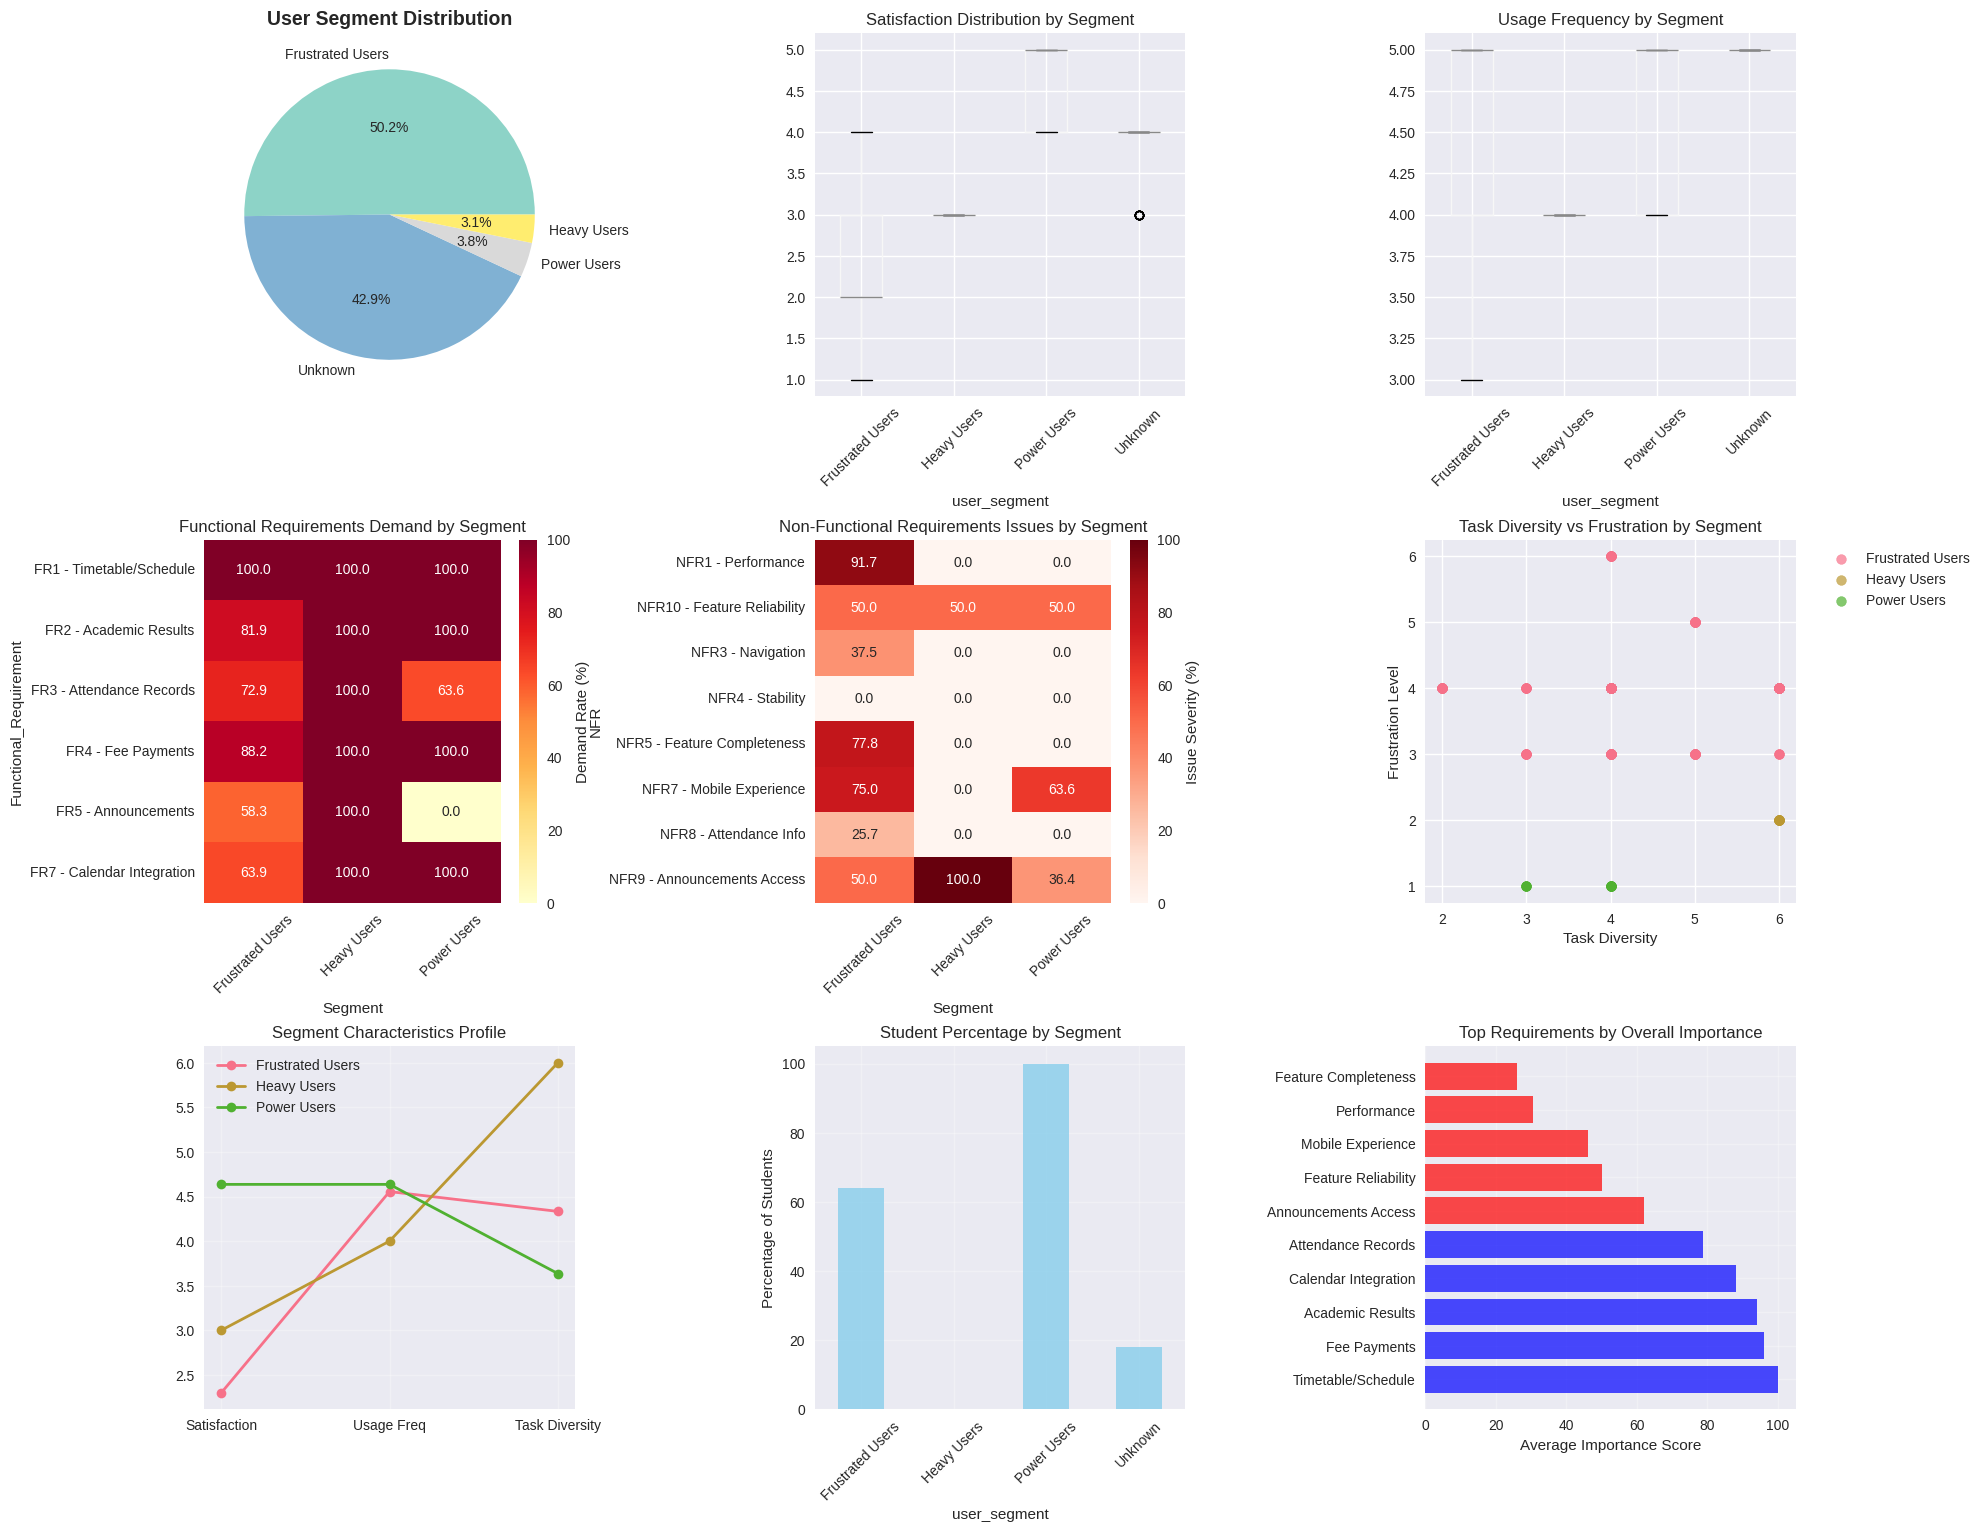

✓ Segmentation visualizations created and saved to: ../media/segmentation_visualizations.png

9. EXPORTING SEGMENTATION REPORT
----------------------------------
✓ Segmentation report exported to: ../report/izone_segmentation_analysis_report.txt
✓ Data tables exported to: ../report/izone_segmentation_analysis_report_data.xlsx

SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY!
✓ Total responses analyzed: 287
✓ User segments identified: 4
✓ Functional requirements analyzed: 6
✓ Non-functional requirements analyzed: 8
✓ Report exported to: ../report/izone_segmentation_analysis_report.txt

📊 Analysis Results Summary:
   • Total Users Analyzed: 287
   • User Segments: 3
   • Segment Distribution:
     - Frustrated Users: 144 users (50.2%)
     - Power Users: 11 users (3.8%)
     - Heavy Users: 9 users (3.1%)

📁 Output Files Generated:
   • Main Report: ../report/izone_segmentation_analysis_report.txt
   • Data Tables: ../report/izone_segmentation_analysis_report_data.xlsx
   • Visualizations: D

In [13]:
print("Starting iZone User Segmentation & Requirements Analysis")
print("=" * 70)

# Configuration
CLEANED_DATA_PATH = "../data/processed/cleaned_data.csv"
OUTPUT_REPORT_PATH = "../report/izone_segmentation_analysis_report.txt"

# Check if the data file exists
import os
if not os.path.exists(CLEANED_DATA_PATH):
    print(f"❌ Error: Data file '{CLEANED_DATA_PATH}' not found!")
    print("Please ensure the cleaned data file is in the correct location.")
    print("You can update the CLEANED_DATA_PATH variable above.")
    exit(1)

# Run the main analysis
results = main_segmentation_analysis(
    cleaned_data_path=CLEANED_DATA_PATH,
    output_report_path=OUTPUT_REPORT_PATH
)

if results is not None:
    print(f"\n📊 Analysis Results Summary:")
    print(f"   • Total Users Analyzed: {results['summary_stats']['total_responses']}")
    print(f"   • User Segments: {results['summary_stats']['segments_identified']}")
    print(f"   • Segment Distribution:")

    for segment, count in results['summary_stats']['segment_distribution'].items():
        if segment != 'Unknown':
            percentage = (count / results['summary_stats']['total_responses']) * 100
            print(f"     - {segment}: {count} users ({percentage:.1f}%)")

    print(f"\n📁 Output Files Generated:")
    print(f"   • Main Report: {OUTPUT_REPORT_PATH}")
    print(f"   • Data Tables: {OUTPUT_REPORT_PATH.replace('.txt', '_data.xlsx')}")
    print(f"   • Visualizations: Displayed in plots")

    print(f"\n🎯 Key Findings:")
    print(f"   • Most demanding segment for FRs: "
          f"{results['functional_requirements']['pivot'].mean(axis=0).idxmax()}")
    print(f"   • Most affected by NFR issues: "
          f"{results['non_functional_requirements']['pivot'].mean(axis=0).idxmax()}")
    print(f"   • Top functional requirement: "
          f"{results['functional_requirements']['pivot'].mean(axis=1).idxmax()}")
    print(f"   • Top NFR concern: "
          f"{results['non_functional_requirements']['pivot'].mean(axis=1).idxmax()}")

    print(f"\n✅ Analysis completed successfully!")
    print(f"📋 Review the generated report for detailed insights and recommendations.")

else:
    print("❌ Analysis failed. Please check the error messages above.")
